In [1]:
import os
from pelops.datasets.chipper import FrameProducer, ExtractedChip, Methods, Chipper
import cv2
from hdfs3 import HDFileSystem
import xml.etree.ElementTree as ET
from collections import namedtuple
import glob
from PIL import Image
import numpy as np
import itertools
from collections import defaultdict
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

In [24]:
# HDFS IP address or node name
hdfs_location = '0.0.0.0'

# Set Texas ('TX') data source, path to videos and camera name
data_source = 'TX'
video_location = '/datasets/texas_dot/Ending20160903/user/*.mp4'
#camera_name = 'IH37_9th'
#camera_name = 'IH37_Jones' 
camera_name = 'IH10_Martin'

# Set Louisiana ('LA') data source, path to videos and camera name
#data_source = 'LA'
#video_location = '/datasets/louisiana_dot/72/*.mp4'
#camera_name = 'Claiborne1'

# Set xml path and labeled path 
xml_basepath = '/data/fs4/teams/pelops/labelme/annotations/'
image_path = '/data/fs4/teams/pelops/labelme/images/{}'

# Set kernel, threshold and chipping method parameter space
candidate_kernel_sizes = [(5,5),(9,9),(11,11),(15,15),(21,21),(29,29),(33,33)]
candidate_thresholds = [2,4,6,8,10,12,15,17,20,27,33,40,50]
candidate_chipping_methods = [Methods.BACKGROUND_SUB, Methods.OPENCV]

# Set maximum number of top chip scoring results to display
topn = 20

# Set IOU score threshold for a chip to be considered a match with a truth box
iou_threshold = 0.25

# Toggle creation of chipping accuracy visualizations
retain_visualizations = False

# Toggle applying an input mask; Set mask input parameters for apply_mask function in next cell 
apply_input_mask = False

# Toggle expanding the boundary box dimensions; Set box parameter 'amount' for expand_box function in next cell 
apply_box_expander = False

In [25]:
# Connect to HDFS and obtain video filenames
hdfs = HDFileSystem(host=hdfs_location, port=8020)
filenames = hdfs.glob(video_location)

# Format filenames to use as key in sorting
def get_info(filename):
    bname = os.path.basename(filename)
    if data_source=='TX':
        # File naming convention for Texas uses dashes between timestamps
        return bname.split('-')[0], int(bname.split('-')[1])
    elif data_source=='LA':
        # File naming convention for Louisiana uses underscores inside timestamp elements
        return bname.split('_')[0], int(bname.split('_')[1]+bname.split('_')[2]+bname.split('_')[3]+bname.split('_')[4]+bname.split('_')[5].split('.')[0])

# Sort filenames and filter based on camera name, order by timestamp
filenames = sorted(filenames, key=get_info)
filenames_filtered = [filename for filename in filenames if camera_name in filename]

# Creates FrameProducer generator object from first video (by timestamp) in filenames_filtered 
# There needs to be truth data for this video in xml_basepath
fp = FrameProducer([filenames_filtered[0]], hdfs.open)

# Sets numpy array elements on image input_arry to 0 at specific indices based on input data
# ex: input_mask_top=60 will set first 60 rows of image array to 0
def apply_mask(input_arry,input_mask_top=75,input_mask_bottom=300):
    input_arry[:input_mask_top]=0
    input_arry[input_mask_bottom:]=0
    return input_arry

# Increase boundary box size; Used with box_expander parameter of Chipper class
def expand_box(x,y,w,h, amount=5):
    return x-amount, y-amount, w+amount*2, h+amount*2

In [26]:
# Function 
# get_frame_lookup - Takes frame and outputs frame_lookup and chips
# Input
# fp - FrameProducer object 
# kernel_size - Size of convolutional kernel, default=(25,25) and must be odd numbers
# threshold - Threshold value used in OpenCV's threshold function, default=30
# chipping_method - Type of chipping, default = Methods.BACKGROUND_SUB
# Output
# frame_lookup - Dictionary of chip reference values keyed on frame_numbers 
# chips - List of Chipper objects

def get_frame_lookup(fp, 
                     kernel_size=(25,25), 
                     threshold=30, 
                     chipping_method=Methods.BACKGROUND_SUB,
                     mask_modifier=None,
                     box_expander=None
                    ):
    chipper = Chipper(fp, 
                  mask_modifier=mask_modifier,
                  kernel_size = kernel_size,
                  threshold = threshold,
                  box_expander=box_expander,
                  chipping_method=chipping_method)

    # Get chips by frame number
    chips = []
    for frame_chips in chipper:
        chips.extend(frame_chips)

    from collections import defaultdict
    frame_lookup = defaultdict(list)
    for ec in chips:
        frame_lookup[ec.frame_number].append(ec)
    return frame_lookup, chips

In [27]:
# Get XML file name based on orignal image file name and frame
def get_xml_name(filename, frame_number):   
    return '{}_{}_.xml'.format(os.path.basename(filename),frame_number)

# Define namedtuple for bounding box attributes
BBox =namedtuple('BBox', ['x','y', 'w', 'h'])

# Take list of polygon dimensions and return bounding box dimensions of X,Y,width,height 
def get_x_y_w_h(bbox):
    xs = [x for x,y in bbox]
    ys = [y for x,y in bbox]
    min_x = min(xs)
    min_y = min(ys)
    max_x = max(xs)
    max_y = max(ys)
    return BBox(x=min_x, 
                y=min_y, 
                w=max_x-min_x, 
                h=max_y-min_y)

# Obtain bounding boxes from XML objects, return frame_filename and bounding boxes
def get_bboxes_from_xml(xml_obj):
    for top_level_tag in xml_obj.iter('filename'):
        frame_filename = top_level_tag.text
    bboxes = []
    for top_level_tag in xml_obj.iter('object'):
        for polygon in top_level_tag.iter('polygon'):
            pts = []
            for pt in polygon.iter('pt'):
                x = None
                y = None
                for dim in pt.iter():
                    if dim.tag == 'x':
                        x = int(dim.text)
                    elif dim.tag == 'y':
                        y = int(dim.text)
                if x and y:
                    pts.append((x,y))
            bboxes.append(get_x_y_w_h(pts))
    return frame_filename, bboxes

# Obtain bounding boxes from filename
def get_bboxes_from_file(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    return get_bboxes_from_xml(root)

In [28]:
# Build xml_files_lookup dictionary from xml_basepath
xml_files_lookup = {}
for filename in glob.glob(os.path.join(xml_basepath, '*')):
    xml_files_lookup[os.path.basename(filename)] = filename

In [29]:
# Find intersection union score for two bounding boxes and return X,Y,width,height
def get_intersection_union(bbox1, bbox2):
    # Top left of intersection
    xA = max(bbox1.x, bbox2.x)
    yA = max(bbox1.y, bbox2.y)
    
    # Bottom right
    xB = min(bbox1.x+bbox1.w, bbox2.x+bbox2.w)
    yB = min(bbox1.y+bbox1.h, bbox2.y+bbox2.h)
    width = xB-xA
    height = yB-yA
    if width < 0 or height < 0:
        return None
    return (xA, yA, width, height)

# Calculate intersection over union (IoU) score for two bounding boxes
def get_iou(bbox1, bbox2):
    # Top left of intersection
    xA = max(bbox1.x, bbox2.x)
    yA = max(bbox1.y, bbox2.y)
    
    # Bottom right
    xB = min(bbox1.x+bbox1.w, bbox2.x+bbox2.w)
    yB = min(bbox1.y+bbox1.h, bbox2.y+bbox2.h)
    width = xB-xA
    height = yB-yA
    if width < 0 or height < 0:
        return 0
    else:
        intersectionArea = (xB - xA + 1) * (yB - yA + 1)
        #unionArea = bbox1.w*bbox1.h + bbox2.w*bbox2.h
        # Per http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
        unionArea = (bbox1.w+1)*(bbox1.h+1) + (bbox2.w+1)*(bbox2.h+1)
        
        return intersectionArea/float(unionArea - intersectionArea)

    #return (xA, yA, width, height)   

In [30]:
# Visually plot performance of predicted bounding box and ground truth bounding box for filename
def visualize_perf(filename, bboxes1, bboxes2):    
    frame = Image.open(image_path.format(filename))
    
    from PIL import ImageDraw
    dr = ImageDraw.Draw(frame)
    for box in bboxes1:
        x, y, w, h = box.x, box.y, box.w, box.h
        dr.rectangle(((x,y),(x+w,y+h)), fill=None, outline = "rgb(0,255,0)")
    for box in bboxes2:
        x, y, w, h = box.x, box.y, box.w, box.h
        dr.rectangle(((x,y),(x+w,y+h)), fill=None, outline = "rgb(255,0,0)")
    
    '''
    # OpenCV method for drawing bounding boxes doesn't always render as expected in Jupyter 
    frame = np.uint8(frame)    
    for box in bboxes1:
        x, y, w, h = box.x, box.y, box.w, box.h
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),1)
    for box in bboxes2:
        x, y, w, h = box.x, box.y, box.w, box.h
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),1)    
    # Uncomment following section to plot blue rectangles for truth/chip interection
    intersection = get_intersection_union(bboxes1[0], bboxes2[0])
    if intersection:
        x,y,w,h = intersection
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),5)
    '''
    return frame

In [31]:
# Score performance of chipping against ground truth for list of frames and associated chips
def score_frame_lookup(frame_lookup, chips):
    video_ious = []
    video_labels = []
    plots = []
    for frame_number in sorted(frame_lookup):
        chips = frame_lookup[frame_number]
        bname = os.path.basename(chips[0].filename)
        xml_filename = get_xml_name(bname, frame_number)
        if xml_filename in xml_files_lookup:
            xml_full_filename = xml_files_lookup[xml_filename]
            frame_image, truth_bboxes = get_bboxes_from_file(xml_full_filename)
            chip_lookup = defaultdict(lambda : -1)
            truth_lookup = defaultdict(lambda : -1)
            truthchip_scores = defaultdict(lambda : -1)
                       
            # Build dictionary of iou scores by comparing each truth box vs all proposed chips
            for truth_bbox in range(len(truth_bboxes)):
                for chip in range(len(chips)): 
                    score = get_iou(chips[chip], truth_bboxes[truth_bbox])
                    # Only evaluate chip if score is better than iou_threshold
                    if score>iou_threshold:
                        # This truth_bbox currently has no matching chip
                        if chip_lookup[truth_bbox]==-1:
                            # This chip hasn't been used previously with another truth_bbox
                            if truth_lookup[chip]==-1:
                                truth_lookup[chip]=truth_bbox
                                chip_lookup[truth_bbox]=chip
                                truthchip_scores[(truth_bbox,chip)]=score
                            # This chip has already been used on a different truth box
                            else:
                                other_box = truth_lookup[chip]
                                # If current chip's score is better than previous chip/truth overlap, replace it
                                if score > truthchip_scores[(other_box,chip)]:
                                    del truthchip_scores[(other_box,chip)]
                                    del chip_lookup[other_box]
                                    truth_lookup[chip]=truth_bbox
                                    chip_lookup[truth_bbox]=chip
                                    truthchip_scores[(truth_bbox,chip)]=score
                        # This truth_bbox already has a matching chip
                        else:
                            other_chip = chip_lookup[truth_bbox]
                            # If current chip's score is better than previous chip/truth overlap, replace it
                            if score > truthchip_scores[(truth_bbox,other_chip)]:
                                del truthchip_scores[(truth_bbox,other_chip)]
                                del truth_lookup[other_chip]
                                truth_lookup[chip]=truth_bbox
                                chip_lookup[truth_bbox]=chip
                                truthchip_scores[(truth_bbox,chip)]=score
                                
            # Retrieve IOU scores for the truth_bboxes found in this frame (true positives)
            frame_ious = [truthchip_scores[x] for x in truthchip_scores if truthchip_scores[x]>0]
            for frame_iou in frame_ious: video_ious.append(frame_iou)
            boxes_found = len(frame_ious)
            for i in range(boxes_found): video_labels.append((1,1))
            
            # Add IOU and F1 score penalties for missed truth_bboxes (false negatives)
            for i in range(len(truth_bboxes)-boxes_found): 
                video_ious.append(0)
                video_labels.append((1,0))
                
            # Add IOU and F1 score penalties for proposed chips with no corresponding truth_bbox (false positives)            
            for i in range(len(chips)-boxes_found): 
                video_ious.append(0)
                video_labels.append((0,1))
                                    
            if retain_visualizations:
                frame = visualize_perf(frame_image, truth_bboxes, chips)
                plots.append([frame,frame_number])
    
    expected=[x[0] for x in video_labels]
    predicted=[y[1] for y in video_labels]
    return np.mean(video_ious), metrics.f1_score(expected,predicted), plots

In [32]:
# Calculate chipping scores
score_strings = []
visualizations = []

if apply_input_mask:
    mask_modifier = apply_mask
else:
    mask_modifier = None
if apply_box_expander:
    box_expander = expand_box
else:
    box_expander = None

for kernel_size in candidate_kernel_sizes:
    print("Processing kernel",kernel_size)
    for threshold in candidate_thresholds:
        for chipping_method in candidate_chipping_methods:
            frame_lookup, chips = get_frame_lookup(fp, 
                            kernel_size=kernel_size,
                            threshold=threshold, 
                            chipping_method=chipping_method,
                            mask_modifier=mask_modifier,
                            box_expander=box_expander)
            iouscore, f1score, plots = score_frame_lookup(frame_lookup, chips)
            visualizations.extend(plots)
            score_strings.append([kernel_size, threshold, chipping_method, iouscore, f1score])
print("Done")

Processing kernel (11, 11)
Done


In [33]:
# Print out top n IOU results from chipping scores
print("Video Location:",video_location)
print("Camera Name:",camera_name)
print("Input Mask:",apply_input_mask)
print("Box Expander:",apply_box_expander)
print("[Kernel, Threshold, Chipping Method, IOU Score]")
for result in sorted(score_strings, key=lambda x: x[3], reverse=True)[:topn]:
   print('{}, {}, {}, IOU: {}'.format(result[0],result[1],result[2],result[3]))

Video Location: /datasets/texas_dot/Ending20160903/user/*.mp4
Camera Name: IH10_Martin
Input Mask: False
Box Expander: False
[Kernel, Threshold, Chipping Method, IOU Score]
(11, 11), 8, Methods.OPENCV, IOU: 0.2634147391101531


In [34]:
# Print out top n F1 Score results from chipping scores
print("Video Location:",video_location)
print("Camera Name:",camera_name)
print("Input Mask:",apply_input_mask)
print("Box Expander:",apply_box_expander)
print("[Kernel, Threshold, Chipping Method, F1 Score]")
for result in sorted(score_strings, key=lambda x: x[4], reverse=True)[:topn]:
   print('{}, {}, {}, F1: {}'.format(result[0],result[1],result[2],result[4]))

Video Location: /datasets/texas_dot/Ending20160903/user/*.mp4
Camera Name: IH10_Martin
Input Mask: False
Box Expander: False
[Kernel, Threshold, Chipping Method, F1 Score]
(11, 11), 8, Methods.OPENCV, F1: 0.583963691376702


Frame number: 4950


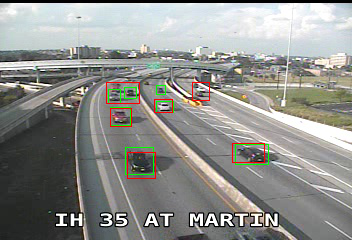

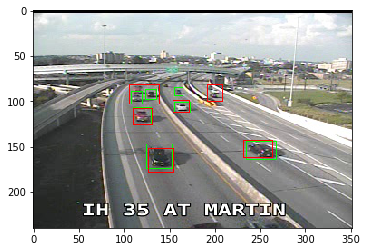

In [780]:
# Execute cell repeatedly to cycle through frame plots
if retain_visualizations:
    try:
        index+=1
        print("Frame number:",visualizations[index][1])
        display(visualizations[index][0])
        # Uncomment to show x,y coordinate axes for calculating input mask parameters
        plt.imshow(visualizations[index][0])
    except:
        index=0
        if len(visualizations):
            print("Frame number:",visualizations[index][1])
            display(visualizations[index][0])
            # Uncomment to show x,y coordinate axes for calculating input mask parameters
            plt.imshow(visualizations[index][0])
else:
    print("There are no plots because 'retain_visualizations' is", retain_visualizations)

In [642]:
# Full experiment results
print("Video Location:",video_location)
print("Camera Name:",camera_name)
print("Input Mask:",apply_input_mask)
print("Box Expander:",apply_box_expander)
print("[Kernel, Threshold, Chipping Method, IOU Score]")
for line in score_strings: 
    print('{}, {}, {}, IOU: {}'.format(line[0],line[1],line[2],line[3]))

Video Location: /datasets/texas_dot/Ending20160903/user/*.mp4
Camera Name: IH10_Martin
Input Mask: False
Box Expander: False
[Kernel, Threshold, Chipping Method, IOU Score]
(15, 15), 17, Methods.BACKGROUND_SUB, IOU: 0.2688837927607692


In [454]:
# Full experiment results
print("Video Location:",video_location)
print("Camera Name:",camera_name)
print("Input Mask:",apply_input_mask)
print("Box Expander:",apply_box_expander)
print("[Kernel, Threshold, Chipping Method, F1 Score]")
for line in score_strings: 
    print('{}, {}, {}, F1: {}'.format(line[0],line[1],line[2],line[4]))

Video Location: /datasets/texas_dot/Ending20160903/user/*.mp4
Camera Name: IH10_Martin
Input Mask: False
Box Expander: False
[Kernel, Threshold, Chipping Method, F1 Score]
(15, 15), 17, Methods.BACKGROUND_SUB, F1: 0.6460753487856065


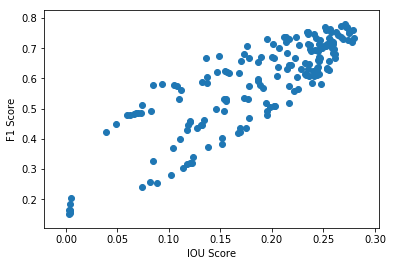

In [305]:
# Plot IOU scores vs F1 Scores for Experiments
opencv_iou_scores = [x[3] for x in score_strings] 
opencv_f1_scores = [x[4] for x in score_strings] 
plt.scatter(opencv_iou_scores,opencv_f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('IOU Score')
plt.show()